# Generate cloud IC for ART

A cloud is a ball of uniform-density monatomic H+He gas, embeded in a uniform density background

In [532]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [318]:
# compute the unit conversion factors
import astropy.units as u
import astropy.constants as c
from astropy.units import cds

m_H = 1.00784 # (u)
m_He = 4.002602 # (u)

print('[u cm^-3 pc^3] -> [Msun]: %.8f'%(c.u * u.cm**-3 * u.pc**3).to(u.Msun).value)
print('[G Msun^2 px^-1] -> [1e40 erg]: %.8f'%(cds.G * u.Msun**2 * u.pc**-1).to(1e40*u.erg))
print('[k_B K cm^-3 pc^3] -> [1e40 erg]: %.8f'%(cds.k * cds.K * u.cm**-3 * u.pc**3).to(1e40*u.erg))
print('[u km^2 s^-2 cm^-3 pc^3] -> [1e40 erg]: %.8f'%(c.u * u.km**2 * u.s**-2 * u.cm**-3 * u.pc**3).to(1e40*u.erg).value)

print('[pc] -> [cm]: %.8e'%(u.pc).to(u.cm))
print('[pc km^-1 s] -> [Myr]: %.8f'%(u.pc * u.km**-1 * u.s).to(u.Myr))
print('[g cm^-3] -> [Msun pc^-3]: %.8e'%(u.g * u.cm**-3).to(u.Msun * u.pc**-3))

[u cm^-3 pc^3] -> [Msun]: 0.02453549
[G Msun^2 px^-1] -> [1e40 erg]: 8.55198635
[k_B K cm^-3 pc^3] -> [1e40 erg]: 0.40563453
[u km^2 s^-2 cm^-3 pc^3] -> [1e40 erg]: 48.78662028
[pc] -> [cm]: 3.08567758e+18
[pc km^-1 s] -> [Myr]: 0.97779222
[g cm^-3] -> [Msun pc^-3]: 1.47756204e+22


In [325]:
# define parameters

root_level = 6
max_level  = 6

XHe        = 0.25    # He mass abundance, 0.25 for ART's default value
size_box   = 256.0   # box size (pc)
r_cloud    = 64.0    # cloud radius (pc)
n_bg       = 1e-6    # background number density (cm^-3)
n_cloud    = 10.0    # cloud number density (cm^-3)
temp       = 10.0    # temperature (K)
gamma      = 5.0/3.0 # adiabatic index, 5/3 for monatomic hydrogen
alpha      = 1.0     # vrial parameter
n_power    = -4.0    # exponent of power spectrum
Z_cloud    = 0.1     # metallicity

# derived values
pmass             = 1/((1-XHe)/m_H + XHe/m_He) # average particle mass in Hydrogen atoms
num_root_level    = 2**root_level
num_max_level     = 2**max_level
num_refined_level = num_max_level / num_root_level
size_root_level   = size_box / num_root_level # (pc)
size_max_level    = size_box / num_max_level # (pc)
rho_bg            = pmass * 0.02453549 * n_bg # (Msun pc^-3)
rho_cloud         = pmass * 0.02453549 * n_cloud # (Msun pc^-3)
mass_cloud        = rho_cloud * (4*np.pi/3) * r_cloud**3 # (Msun)
Ep_cloud          = 8.55198635 * (-3/5) * mass_cloud**2 / r_cloud # cloud grav energy (1e40 erg)
Et_cloud          = 0.40563453 * temp * (4*np.pi/3) * n_cloud * r_cloud**3 / (gamma-1) # cloud thermal energy (1e40 erg)
Ek_cloud          = (-Ep_cloud*alpha)/2 - Et_cloud # cloud kinetic energy (1e40 erg)

assert Ek_cloud >= 0

print('root grid size: %g pc'%size_root_level)
print('min grid size: %g pc'%size_max_level)

print('background density: %.3g Msun pc^-3'%rho_bg)
print('cloud density: %.3g Msun pc^-3'%rho_cloud)
print('cloud mass: %.3g Msun'%mass_cloud)

print('cloud grav energy: %.3g erg'%Ep_cloud)
print('cloud thermal energy: %.3g erg'%Et_cloud)
print('cloud kinetic energy: %.3g erg'%Ek_cloud)

root grid size: 4 pc
min grid size: 4 pc
background density: 3.04e-08 Msun pc^-3
cloud density: 0.304 Msun pc^-3
cloud mass: 3.34e+05 Msun
cloud grav energy: -8.94e+09 erg
cloud thermal energy: 6.68e+07 erg
cloud kinetic energy: 4.41e+09 erg


In [335]:
# set positions
# unit = size_root_level

# origin
xo = yo = zo = num_root_level / 2

# center of root cells
shape_root = (num_root_level,num_root_level,num_root_level)
x_root, y_root, z_root = np.meshgrid(np.arange(num_root_level)+0.5, np.arange(num_root_level)+0.5, np.arange(num_root_level)+0.5)
x_root = x_root.flatten()
y_root = y_root.flatten()
z_root = z_root.flatten()
r_root = np.sqrt((x_root-xo)**2 + (y_root-yo)**2 + (z_root-zo)**2)
rho_root = np.full_like(x_root, fill_value=rho_bg) # (Msun pc^-3)

mask_refined = r_root < r_cloud/size_root_level

# center of refined cells relative to the parent root cell
shape_refined = (num_refined_level,num_refined_level,num_refined_level)
dx, dy, dz = np.meshgrid(np.arange(num_refined_level)+0.5, np.arange(num_refined_level)+0.5, np.arange(num_refined_level)+0.5)
dx = dx.flatten() / num_refined_level - 0.5
dy = dy.flatten() / num_refined_level - 0.5
dz = dz.flatten() / num_refined_level - 0.5

x_refined = np.concatenate(dx + x_root[mask_refined, np.newaxis], axis=0)
y_refined = np.concatenate(dy + y_root[mask_refined, np.newaxis], axis=0)
z_refined = np.concatenate(dz + z_root[mask_refined, np.newaxis], axis=0)
rho_refined = np.full_like(x_refined, fill_value=rho_cloud) # (Msun pc^-3)

In [292]:
# set velocities

# root cells: zero velocity
vx_root = vy_root = vz_root = np.zeros_like(x_root)

# refined cells: turbulence from Gaussian random fields
# set origin to the min coordinates
xo_fft = np.min(x_refined)
yo_fft = np.min(y_refined)
zo_fft = np.min(z_refined)

x_fft = ((x_refined - xo_fft) * num_refined_level).astype(int)
y_fft = ((y_refined - yo_fft) * num_refined_level).astype(int)
z_fft = ((z_refined - zo_fft) * num_refined_level).astype(int)

# set range to the min 2-power that is greater than all ranges
range = 2**np.ceil(np.log2(np.max((np.max(x_fft), np.max(y_fft), np.max(z_fft))))).astype(int) 

# index in the flattened FFT outputs
idx_fft = np.ravel_multi_index(np.array((x_fft, y_fft, z_fft)), (range,range,range)) 

# power spectrum
k = np.fft.fftfreq(range, 1/num_refined_level)
kx, ky, kz = np.meshgrid(k, k, k)
kabs = np.sqrt(kx**2 + ky**2 + kz**2)
kabs[kabs==0] = np.inf # fix the zero frequency point
P = kabs**n_power # power spectrum

# inverse FFT to get velocity amplitude
rng = np.random.default_rng(1)
amp_vx = num_refined_level**3*np.fft.ifftn(rng.normal(loc=0, scale=np.sqrt(P))+rng.normal(loc=0, scale=np.sqrt(P))*1j).real
amp_vy = num_refined_level**3*np.fft.ifftn(rng.normal(loc=0, scale=np.sqrt(P))+rng.normal(loc=0, scale=np.sqrt(P))*1j).real
amp_vz = num_refined_level**3*np.fft.ifftn(rng.normal(loc=0, scale=np.sqrt(P))+rng.normal(loc=0, scale=np.sqrt(P))*1j).real

# un-normalized velocities, let's assume it's in km s^-1 
vx_refined = amp_vx.flatten()[idx_fft]
vx_refined -=np.mean(vx_refined)
vy_refined = amp_vy.flatten()[idx_fft]
vy_refined -=np.mean(vy_refined)
vz_refined = amp_vz.flatten()[idx_fft]
vz_refined -=np.mean(vz_refined)

# un-normalized kinetic energy in erg
Ek_cloud_raw = pmass * 48.78662028 * np.sum(n_cloud * size_max_level**3 * (vx_refined**2+vy_refined**2+vz_refined**2) / 2) # (1e40 erg)
factor = np.sqrt(Ek_cloud/Ek_cloud_raw)
print('Un-normalized velocities need to be boosted by %.2e. This value should not depend on max_level for small n_power'%factor)

# normalized velocities, in km s^-1
vx_refined *= factor
vy_refined *= factor
vz_refined *= factor

Un-normalized velocities need to be boosted by 1.70e+01. This value should not depend on max_level for small n_power


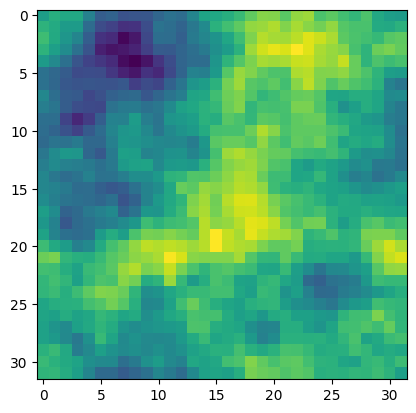

In [295]:
# check gaussian random field
plt.imshow(amp_vx[0])
plt.show()

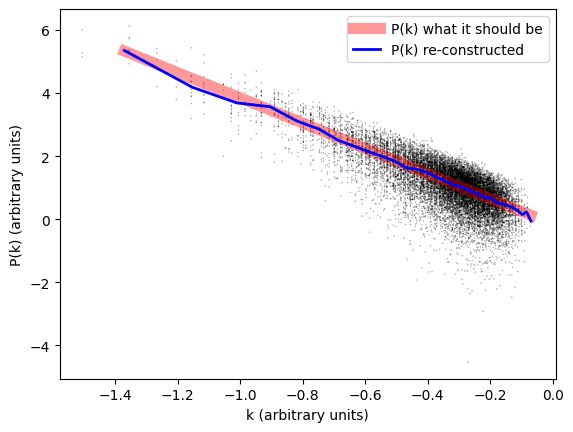

In [304]:
# check power spectrum
amp_k = np.fft.fftn(amp_vx)
plt.scatter(np.log10(kabs), np.log10(amp_k.real**2+amp_k.imag**2), s=1, ec='none', c='k', alpha=0.2)
bins = np.log10(np.linspace(np.min(kabs), np.max(np.abs(kx))*np.sqrt(3), 32))
y = stats.binned_statistic(np.log10(kabs).flatten(), np.log10(amp_k.real**2+amp_k.imag**2).flatten(), statistic='median', bins=bins)[0]
x = (bins[1:] + bins[:-1]) / 2
plt.plot(x, x*n_power-np.log10(2)/2, c='r', lw=8, alpha=0.4, label='P(k) what it should be')
plt.plot(x, y, c='b', lw=2, label='P(k) re-constructed')

plt.xlabel('k (arbitrary units)')
plt.ylabel('P(k) (arbitrary units)')
plt.legend()
plt.show()

In [337]:
# combine root and refined

x = np.concatenate((x_refined, x_root[~mask_refined])) # (size_root_level)
y = np.concatenate((y_refined, y_root[~mask_refined])) # (size_root_level)
z = np.concatenate((z_refined, z_root[~mask_refined])) # (size_root_level)
vx = np.concatenate((vx_refined, vx_root[~mask_refined])) # (km s^-1)
vy = np.concatenate((vy_refined, vy_root[~mask_refined])) # (km s^-1)
vz = np.concatenate((vz_refined, vz_root[~mask_refined])) # (km s^-1)
rho = np.concatenate((rho_refined, rho_root[~mask_refined])) # (Msun pc^-3)

# convert rho to code unit
rho *= size_root_level**3

# convert to more convenient units. NOTE: it's not ART's default uinits (cgs)!
# x *= size_root_level # convert to pc
# y *= size_root_level
# z *= size_root_level

xvrho = np.column_stack((x,y,z,vx,vy,vz,rho))

np.savetxt('cloud_ic.txt', xvrho, fmt='%g %g %g %g %g %g %g')

In [332]:
x_root

array([ 0.5,  0.5,  0.5, ..., 63.5, 63.5, 63.5])

In [343]:
np.log2(65536)

16.0

In [342]:
3.155760e+12*u.s.to(u.Myr)

0.1

In [348]:

header = [size_root_level, root_level]
np.savetxt('cloud_ic_header.txt', header, fmt='%g')

In [355]:
2**4*32

512

In [399]:
2*(((13.54040134 *cds.K *cds.k/(1.2*c.u) + (0.2*u.km/u.s)**2) *np.pi /cds.G/(1.29877955e-23*u.g*u.cm**-3))**(1/2)).to(u.pc)

<Quantity 45.13780932 pc>

In [402]:
(1.2*c.u*10/u.cm**3).to(u.Msun/u.pc**3)

<Quantity 0.29442594 solMass / pc3>

In [375]:
(2.40423313e-21*u.g*u.cm**-3).to(u.Msun*u.pc**-3)

<Quantity 35.5240361 solMass / pc3>

In [398]:
(((10 *cds.K *cds.k/(1.2*c.u)  + (1.39*u.km/u.s)**2) *np.pi /cds.G/(0.00304 *u.Msun*u.pc**-3))**(1/2)).to(u.pc)

<Quantity 693.46278249 pc>

In [385]:
np.sqrt(10 *cds.K *cds.k/(1.2*c.u)).to(u.km/u.s)

<Quantity 0.2632246 km / s>

In [381]:
(0.5427*(cds.G * 0.00304 *u.Msun* u.pc**-3)**(-1/2)).to(u.Myr)

<Quantity 146.75370131 Myr>

In [407]:
print('[G^-1/2 Msun^-1/2 pc^3/2]: %.8f'%np.sqrt(1/(cds.G*u.Msun/u.pc**3)).to(u.Myr).value)

[G^-1/2 Msun^-1/2 pc^3/2]: 14.90960143


In [408]:
import yt

In [614]:
def make_prj(a, d):
    root_level = 6
    size_box = 256.0 # pc
    num_root_level = 2**root_level
    size_root_level = size_box / num_root_level

    current_time = a.current_time.to('Myr').value.item() # Myr
    
    x = y = np.arange(0,size_box+0.5*size_root_level,size_root_level)
    h = stats.binned_statistic_2d(d['gas', 'x'].to('pc').value, d['gas', 'y'].to('pc').value, d['gas', 'mass'].to('Msun').value, statistic='sum', bins=[x,y])[0]
    h /= size_root_level**2 # Msun pc^-2
    im = plt.imshow(h, origin='lower', extent=[0,size_box,0,size_box], norm=LogNorm(vmin=1e2, vmax=1e5))
    
    plt.scatter(d['STAR', 'POSITION_X'].to('pc').value, d['STAR', 'POSITION_Y'].to('pc').value, 
        s=d['STAR', 'MASS'].to('Msun').value/3e3, fc='w', ec='none')
    
    plt.text(0.96*size_box, 0.96*size_box, r'$t=%.1f\ {\rm Myr}$'%current_time, c='w',
            horizontalalignment='right', verticalalignment='top', fontsize=12)
    
    plt.xlabel('x (pc)')
    plt.ylabel('y (pc)')
    
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes((0.79, 0.1, 0.025, 0.8))
    plt.colorbar(im, cax=cax)
    plt.ylabel(r'$\Sigma\ ({\rm M_\odot\,pc^{-2}})$')

    plt.savefig('/Users/ybchen/Downloads/202404_cloud_prj/t%.1f.png'%current_time, bbox_inches ='tight', pad_inches=0.05)
    plt.show()

yt : [INFO     ] 2024-04-15 15:47:29,332 Parameters: current_time              = 0.0 yr
yt : [INFO     ] 2024-04-15 15:47:29,333 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:29,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:29,335 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:29,336 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:30,352 Created 256 chunks for ARTIO


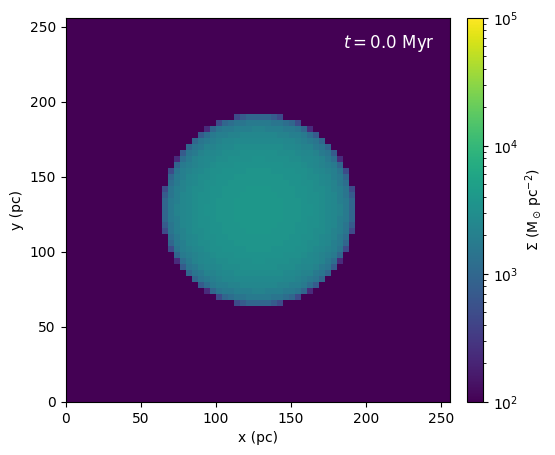

yt : [INFO     ] 2024-04-15 15:47:31,189 Parameters: current_time              = 300824.6210644421 yr
yt : [INFO     ] 2024-04-15 15:47:31,190 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:31,191 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:31,192 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:31,194 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:32,193 Created 256 chunks for ARTIO


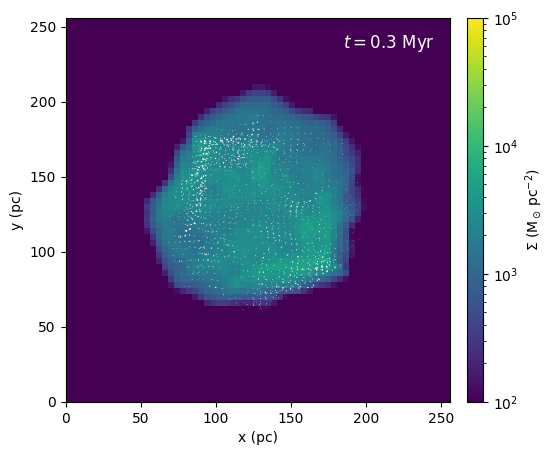

yt : [INFO     ] 2024-04-15 15:47:33,061 Parameters: current_time              = 600957.551343258 yr
yt : [INFO     ] 2024-04-15 15:47:33,062 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:33,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:33,064 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:33,065 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:34,774 Created 256 chunks for ARTIO


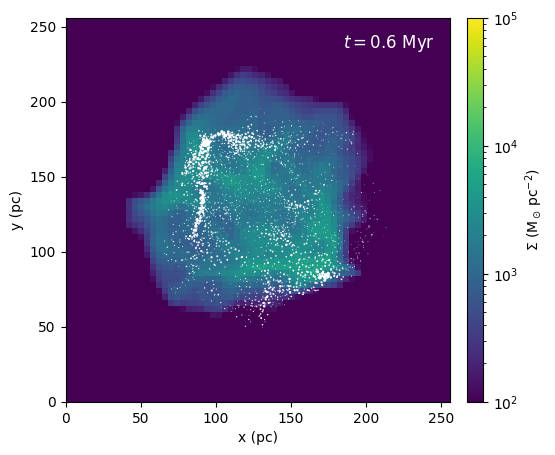

yt : [INFO     ] 2024-04-15 15:47:35,671 Parameters: current_time              = 912936.8734141955 yr
yt : [INFO     ] 2024-04-15 15:47:35,672 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:35,673 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:35,674 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:35,674 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:36,933 Created 256 chunks for ARTIO


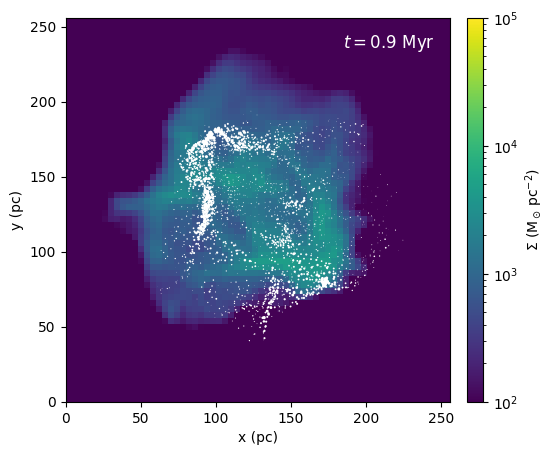

yt : [INFO     ] 2024-04-15 15:47:37,960 Parameters: current_time              = 1207623.9337309322 yr
yt : [INFO     ] 2024-04-15 15:47:37,961 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:37,961 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:37,962 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:37,964 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:39,009 Created 256 chunks for ARTIO


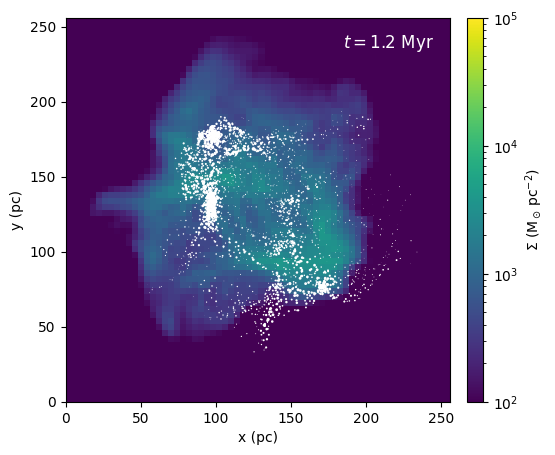

yt : [INFO     ] 2024-04-15 15:47:39,976 Parameters: current_time              = 1503073.8803861458 yr
yt : [INFO     ] 2024-04-15 15:47:39,977 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:39,977 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:39,978 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:39,979 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:41,158 Created 256 chunks for ARTIO


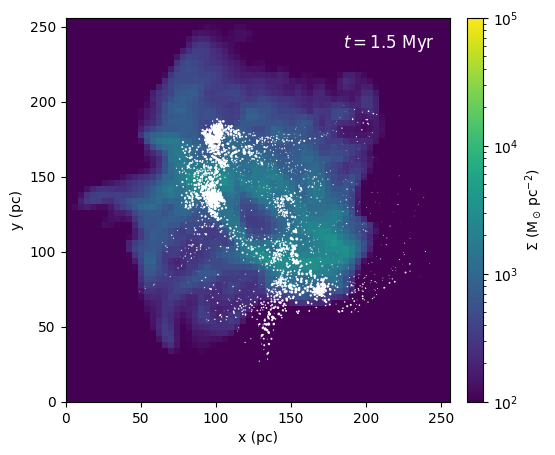

yt : [INFO     ] 2024-04-15 15:47:41,961 Parameters: current_time              = 1800769.2051104435 yr
yt : [INFO     ] 2024-04-15 15:47:41,961 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:41,962 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:41,963 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:41,964 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:42,785 Created 256 chunks for ARTIO


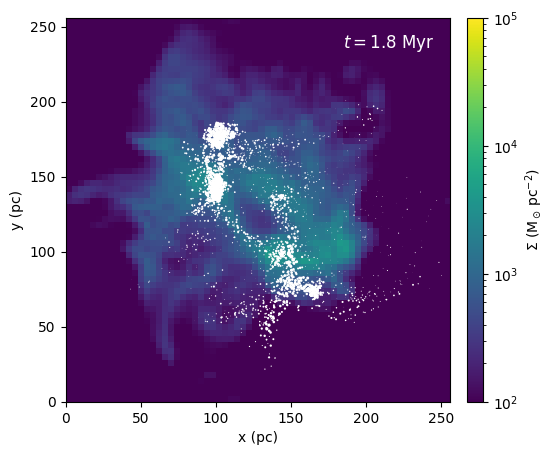

yt : [INFO     ] 2024-04-15 15:47:43,652 Parameters: current_time              = 2104155.501727964 yr
yt : [INFO     ] 2024-04-15 15:47:43,653 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:43,653 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:43,654 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:43,655 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:44,403 Created 256 chunks for ARTIO


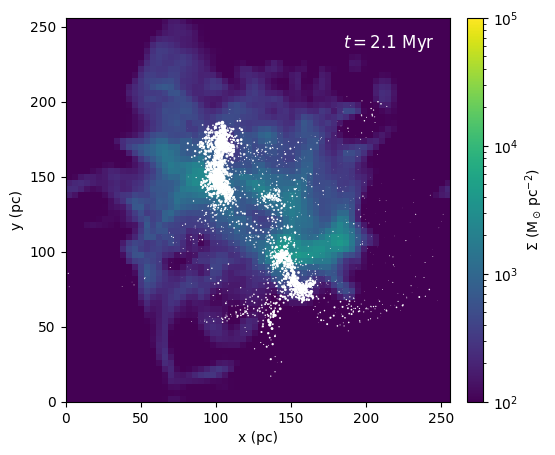

yt : [INFO     ] 2024-04-15 15:47:45,391 Parameters: current_time              = 2407407.1455704947 yr
yt : [INFO     ] 2024-04-15 15:47:45,392 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:45,392 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:45,393 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:45,394 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:46,215 Created 256 chunks for ARTIO


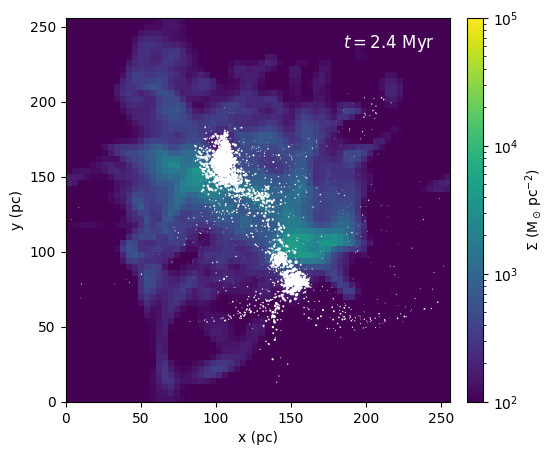

yt : [INFO     ] 2024-04-15 15:47:47,357 Parameters: current_time              = 3002673.627499025 yr
yt : [INFO     ] 2024-04-15 15:47:47,358 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:47,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:47,360 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:47,361 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:49,031 Created 256 chunks for ARTIO


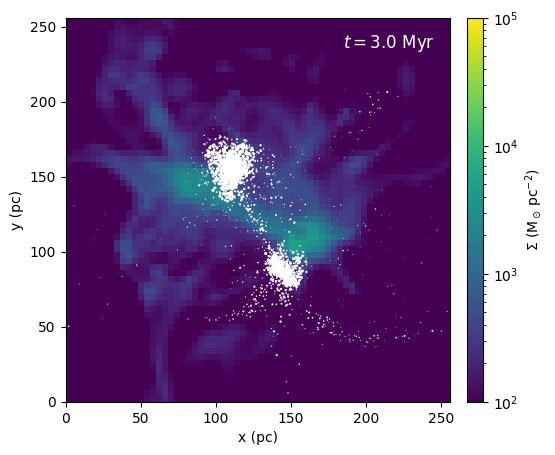

yt : [INFO     ] 2024-04-15 15:47:49,902 Parameters: current_time              = 4003039.5510027003 yr
yt : [INFO     ] 2024-04-15 15:47:49,903 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-15 15:47:49,903 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-15 15:47:49,904 Parameters: domain_right_edge         = [64. 64. 64.]
yt : [INFO     ] 2024-04-15 15:47:49,905 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2024-04-15 15:47:50,750 Created 256 chunks for ARTIO


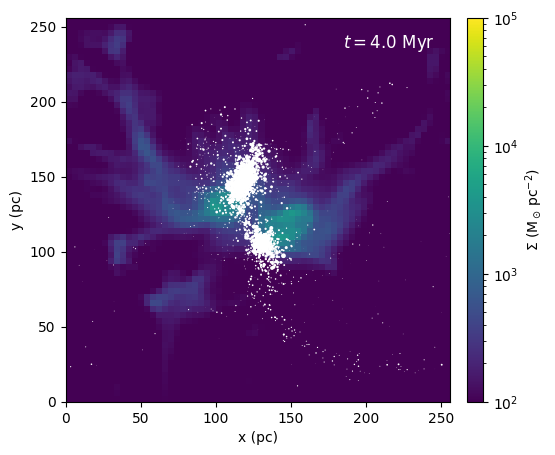

In [615]:
for name in ['000000', '000021','000051', '000089', '000139', '000179', '000220', '000275', '000315', '000385', '000534']:

    a = yt.load('/Users/ybchen/Documents/art_simulations/hydro/cloud/run/out/to_local/snap_%s.art'%name)
    d = a.all_data()
    
    make_prj(a, d)